In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
from pmdarima.arima import auto_arima
from sklearn.preprocessing import MinMaxScaler

from metric import mape, mae, R2_score, mse, rmse
from utils import df2d_to_array3d

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

In [2]:
# data read
data_df = pd.read_csv('../../data/train.csv', encoding='cp949')

In [3]:
data_df.head(1)

,num,date_time,elec_amount,temp,wind_speed,humidity,rainfall,sunshine,no_elec,sunlight_have
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0,0


In [5]:
# 60개 건물 split
data = df2d_to_array3d(data_df)
data.shape

(60, 2040, 8)

In [6]:
# 1번 건물의 전력량 데이터
data_1 = data[0, :, 0]

### 간단한 EDA

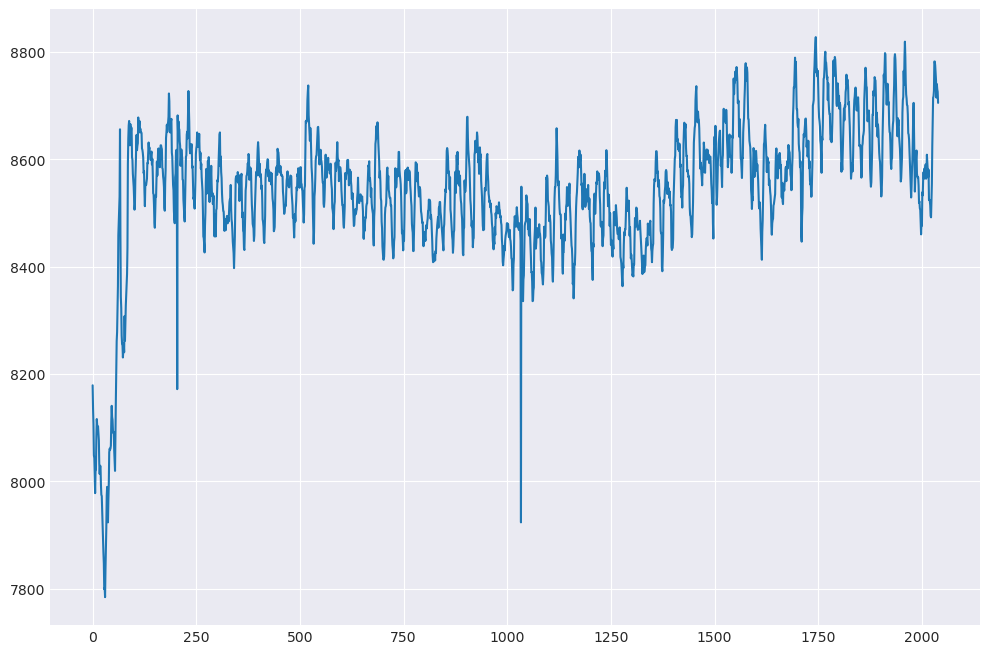

In [7]:
fig = plt.figure(figsize=(12, 8))
plt.plot(data_1)
plt.show()

In [8]:
adf = adfuller(data_1)
print('ADF Statistic: {}'.format(adf[0]))
print('p-value: {}'.format(adf[1]))
print('Critical Values:')
for key, value in adf[4].items():
  print('\t{}: {}'.format(key, value))

ADF Statistic: -5.900663958166336
p-value: 2.783068140030628e-07
Critical Values:
	1%: -3.4336026867364144
	5%: -2.8629768669694458
	10%: -2.5675349256978177


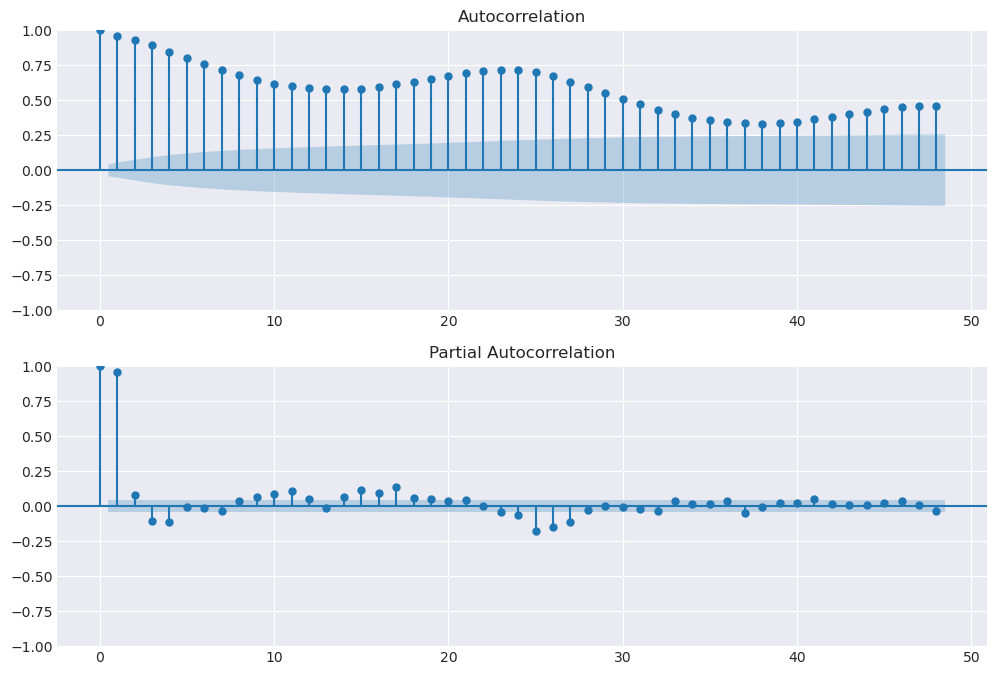

In [9]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data_1, lags=48, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data_1, lags=48, ax=ax2)

### scale 필요

### ARIMA

- trn, tst split

In [7]:
# tst size select
tst_size = int(7 * 24) # 7일 예측
tst_size

168

In [8]:
# trn, tst
trn, tst = data_1[:-tst_size], data_1[-tst_size:]
trn.shape, tst.shape

((1872,), (168,))

- manual ARIMA

In [12]:
ar4 = ARIMA(trn, order=(4,0,0)).fit()

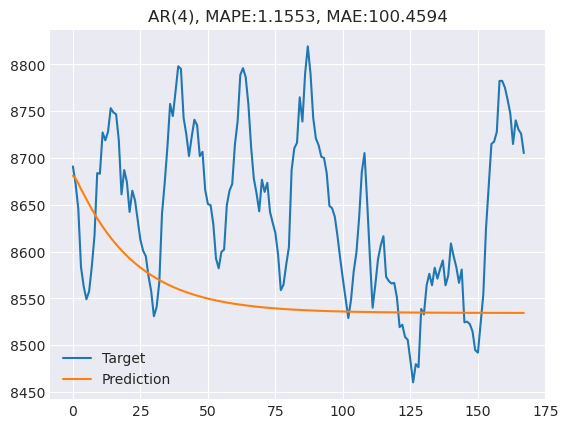

In [13]:
# dynamic = True
prd = ar4.predict(start=1872, end=2039, dynamic=True)

plt.title(f"AR(4), MAPE:{mape(prd, tst):.4f}, MAE:{mae(prd, tst):.4f}")
plt.plot(tst, label="Target")
plt.plot(prd, label=f"Prediction")
plt.legend()
plt.show()

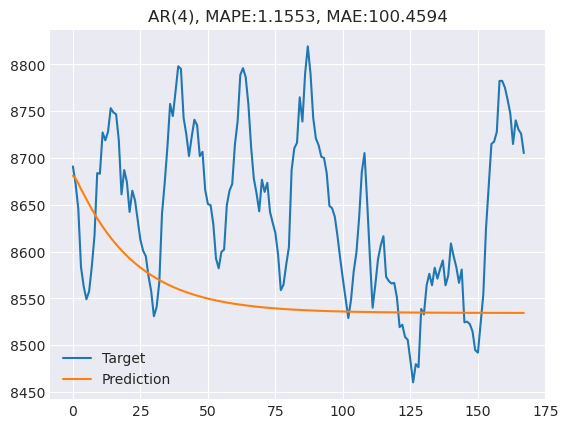

In [29]:
# dynamic = False
prd = ar4.predict(start=1872, end=2039, dynamic=False)

plt.title(f"AR(4), MAPE:{mape(prd, tst):.4f}, MAE:{mae(prd, tst):.4f}")
plt.plot(tst, label="Target")
plt.plot(prd, label=f"Prediction")
plt.legend()
plt.show()

In [15]:
from pmdarima.arima import auto_arima

model_auto = auto_arima(trn, start_p=0, start_q=0, max_d=3, max_p=15, max_q=15, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18717.656, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18681.737, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18687.656, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18715.763, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=18673.456, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=18660.395, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=18662.262, Time=0.18 sec


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=18662.290, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=18667.863, Time=0.47 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=18587.130, Time=1.91 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=18665.772, Time=0.64 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=18662.702, Time=2.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=18663.936, Time=0.63 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=18663.772, Time=0.20 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=18665.948, Time=1.21 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=18586.582, Time=0.83 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=18660.387, Time=0.20 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=18660.352, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=18663.878, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=18664.114, Time=0.30 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=18658.483, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=18662.036, Time=0.51

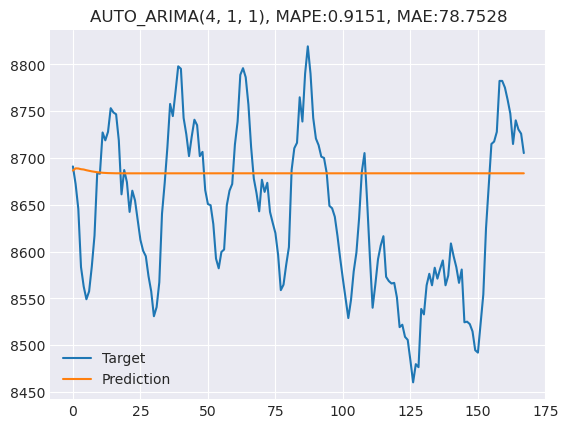

In [16]:
prd = model_auto.predict(tst_size, dynamic=False)

plt.title(f"AUTO_ARIMA(4, 1, 1), MAPE:{mape(prd, tst):.4f}, MAE:{mae(prd, tst):.4f}")
plt.plot(tst, label="Target")
plt.plot(prd, label=f"Prediction")
plt.legend()
plt.show()

- manual arima(4, 0, 0) -> MAPE:1.1553, 100.4594
- auto_arima(4, 1, 1) -> MAPE: 0.9151, MAE:78.7528
- auto_arima를 사용 후 약간의 metric상승이 있었지만 여전히 잘 못맞추고 있는 상태이다

- 학습이 잘 되고 있는지 확인

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


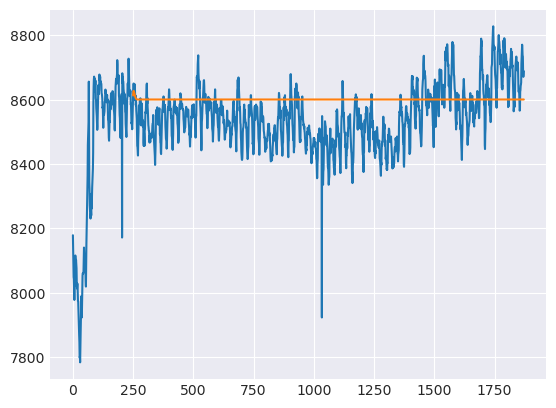

In [19]:
prd = model_auto.predict_in_sample(start=250,dynamic=True)
plt.plot(trn)
plt.plot(range(250, 1872),prd)
plt.legend()
plt.show()

In [17]:
prd = model_auto.predict_in_sample(start=250,dynamic=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


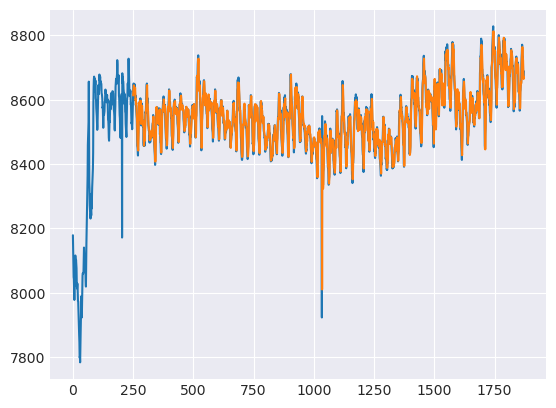

In [18]:
plt.plot(trn)
plt.plot(range(250, 1872),prd)
plt.legend()
plt.show()

- 학습은 잘 되고 있지만, 예측은 전혀 못하고 있는 상황임을 알 수 있다.

### detail한 EDA 필요성을 느낌

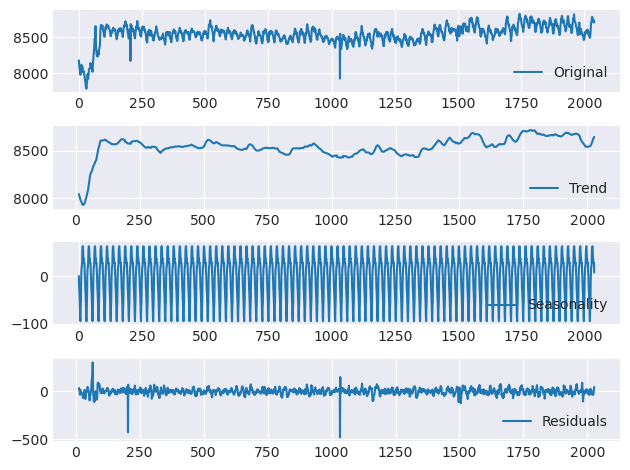

In [14]:
decomposition = seasonal_decompose(data_1, period=24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(data_1, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### 지금까지의 그래프로 본 종합적인 평가
- 그래프 확인 결과 분산을 작게 맞춰야 겠다
- acf, pacf 확인 결과 p = 4
- p-value로 보았을 때 staionary한 기준치인 0.05보다 현저히 작다
- trend: 우상향하는 모습
- seasonality: 24시간 마다의 주기성을 보인다.
- residuals: 3군데에서 이상치를 탐지하였다.<br><br><br>

- 실험 해봐야 할 부분

1. 이상치 수치확인
2. 분산 작게 만들기
3. seasonality를 고려한 sarima사용

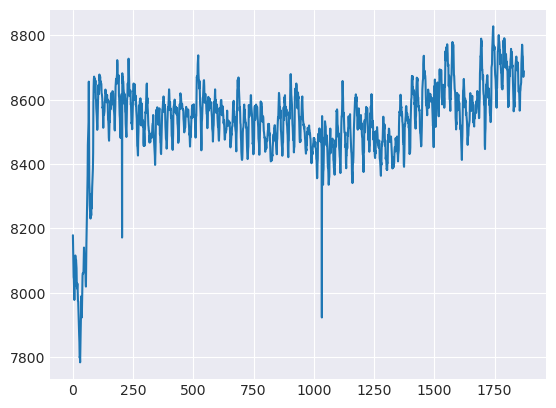

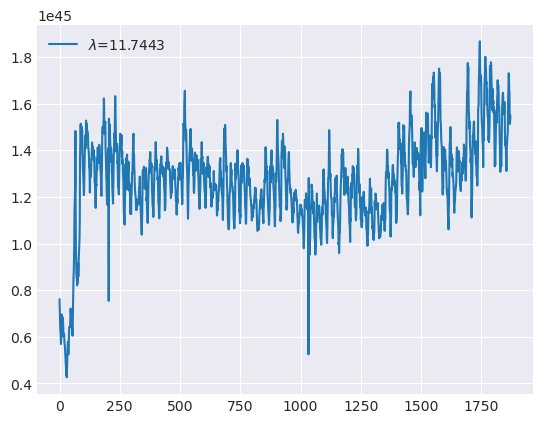

In [9]:
from sktime.transformations.series.boxcox import BoxCoxTransformer
from ipywidgets import interact_manual
import ipywidgets as widgets

# Guerrero method
transformer = BoxCoxTransformer(method='guerrero', sp=24) # 24시간 주기성
trn_guerrero = transformer.fit_transform(trn)

plt.plot(trn)
plt.show()

plt.plot(trn_guerrero, label=f'$\lambda$={transformer.lambda_:.4f}')
plt.legend()
plt.show()

In [10]:
from pmdarima.arima import auto_arima

model_auto = auto_arima(trn_guerrero, start_p=0, start_q=0, max_d=3, max_p=15, max_q=15, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=382262.726, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=382259.853, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=382260.610, Time=0.08 sec


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=382260.831, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=382246.620, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=382238.686, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=382239.757, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=382240.132, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=382225.410, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=382257.887, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=382241.604, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=382240.698, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=382240.679, Time=0.52 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=382223.410, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=382255.887, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=382244.620, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=382238.132, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=382239

In [11]:
# dynamic = True
prd2 = ar4.predict(start=1872, end=2039, dynamic=True)
plt.title(f"AR(4), MAPE:{mape(prd2,tst):.4f}, MAE:{mae(prd2,tst):.4f}, R2_SCORE:{R2_score(prd2,tst):.4f}, RMSE:{rmse(prd2,tst):.4f}")
plt.plot(tst, label="Target")
plt.plot(prd, label=f"Prediction")
plt.legend()
plt.show()

NameError: name 'ar4' is not defined

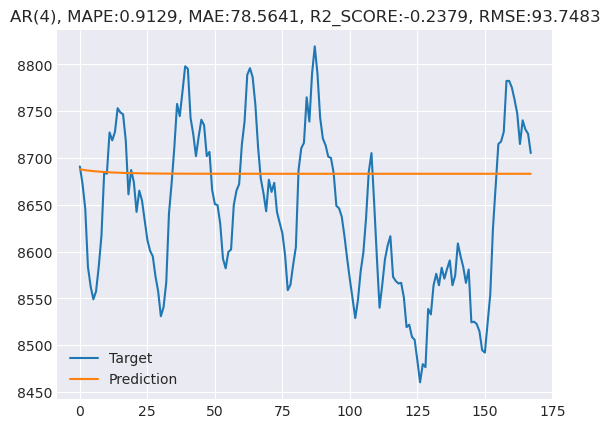

In [19]:
# dynamic = False
prd = model_auto.predict(tst_size, dynamic=False)
prd2 = transformer.inverse_transform(prd)
plt.title(f"AR(4), MAPE:{mape(prd2,tst):.4f}, MAE:{mae(prd2,tst):.4f}, R2_SCORE:{R2_score(prd2,tst):.4f}, RMSE:{rmse(prd2,tst):.4f}")
plt.plot(tst, label="Target")
plt.plot(prd2, label=f"Prediction")
plt.legend()
plt.show()

- AUTO SARIMA

In [10]:
model=auto_arima(trn_guerrero, start_p=0, start_q=0, max_p=15, max_d=3, max_q=15,start_P=0,start_Q=0, max_P=15, max_D=3, max_Q=15, m=24, seasonal=True, trace=True)

NameError: name 'trn_guerrero' is not defined

In [25]:
prd=model.predict(n_periods = tst_size, typ='levels', dynamic=False)
prd = transformer.inverse_transform(prd)

NameError: name 'model' is not defined

In [ ]:
plt.title(f"AUTO_ARIMA, MAPE:{mape(prd, tst):.4f}, MAE:{mae(prd, tst):.4f}")
plt.plot(tst, label="Target")
plt.plot(prd, label=f"Prediction")
plt.legend()
plt.show()

In [27]:
diff_trn_guerrero = pd.DataFrame(trn_guerrero).diff(24)

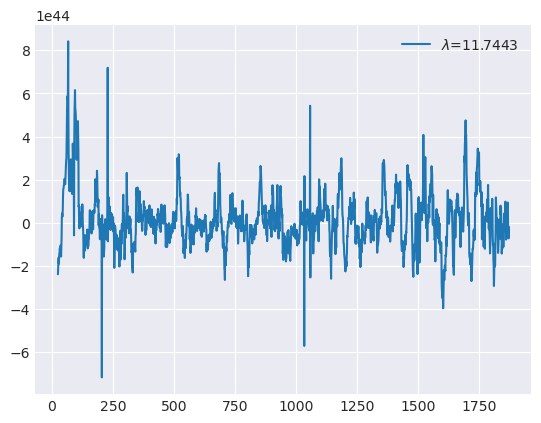

In [28]:
plt.plot(diff_trn_guerrero, label=f'$\lambda$={transformer.lambda_:.4f}')
plt.legend()
plt.show()

- SARIMA 직접 구현

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model2 = SARIMAX(trn_guerrero, order=(5,0,0), seasonal_order=(4,1,0,24))
model_fit = model2.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00892D+02    |proj g|=  1.70477D-01


 This problem is unconstrained.



At iterate    5    f=  1.00840D+02    |proj g|=  2.06220D-02

At iterate   10    f=  1.00837D+02    |proj g|=  1.10782D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     12     15      1     0     0   4.119D-05   1.008D+02
  F =   100.83649512644909     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [27]:
prd2 = model_fit.predict(start=1872, end=1896, dynamic=False)
prd2 = transformer.inverse_transform(prd2)

In [31]:
1872 + 24

1896

In [30]:
167 /24

6.958333333333333

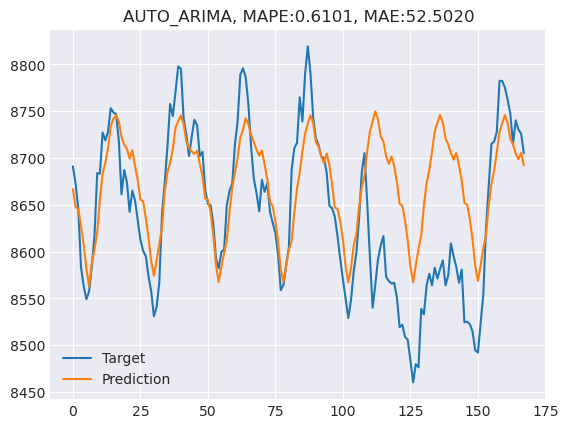

In [28]:
plt.title(f"AUTO_ARIMA, MAPE:{mape(prd2,tst):.4f}, MAE:{mae(prd2,tst):.4f}, R2_SCORE:{R2_score(prd2,tst):.4f}, MSE:{mse(prd2,tst):.4f}, RMSE:{rmse(prd2,tst):.4f}")
plt.plot(tst, label="Target")
plt.plot(prd2, label=f"Prediction")
plt.legend()
plt.show()